In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import sqrt
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from operator import itemgetter

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Assume we pulled the data on 7/01/2002. We will do all calculations relative to this date.

In [4]:
df_data_pt_1 = pd.read_csv("Nomis Solutions_Data Part I.csv")
df_data_pt_1['car_type']=df_data_pt_1['Car  Type']
df_data_pt_1['previous_rate']=df_data_pt_1['Previous Rate']
df_data_pt_1['approve_date']=df_data_pt_1['Approve Date']
df_data_pt_1['competition_rate']=df_data_pt_1['Competition rate']
df_data_pt_1['cost_of_funds']=df_data_pt_1['Cost of Funds']


df_data_pt_1.drop(['Car  Type','Previous Rate','Approve Date','Competition rate','Cost of Funds'],axis=1,inplace=True)
df_data_pt_1.approve_date= pd.to_datetime(df_data_pt_1.approve_date)
df_data_pt_1.previous_rate = df_data_pt_1.previous_rate.apply(lambda x:0 if x == ' ' else float(x))
df_data_pt_2 = pd.read_csv("Nomis Solutions Part II.csv",skiprows=1)

## add in the year , month, and date to cluster against
df_data_pt_1['year'] = df_data_pt_1.approve_date.apply( lambda x: x.year)
df_data_pt_1['month'] = df_data_pt_1.approve_date.apply( lambda x: x.month)
df_data_pt_1['day'] = df_data_pt_1.approve_date.apply( lambda x: x.day)

## fix the naming with tier
df_data_pt_1['tier'] = df_data_pt_1.iloc[:,0]
df_data_pt_1 = df_data_pt_1.iloc[:,1:]

In [5]:
# conver the data column to the 
df_data_pt_1.approve_date = pd.to_datetime(df_data_pt_1.approve_date)

In [6]:
## create a dataframe without data to cluster against
df_data_copy = df_data_pt_1.copy()
df_data_pt_1_no_date = df_data_copy.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Outcome', 'Rate', 'Partner Bin',\
       'car_type', 'previous_rate', 'competition_rate',\
       'cost_of_funds', 'year', 'month', 'day')]

In [7]:
# Drop NA columns
df_data_pt_1.dropna(inplace=True)


In [8]:
 #Drop na columns
df_data_pt_2.dropna(inplace=True)

In [9]:
df_data_pt_1_no_date.dropna(inplace=True)

In [10]:
df_data_pt_1.approve_date.describe()

count                  208077
unique                    861
top       2003-07-28 00:00:00
freq                      718
first     2002-07-01 00:00:00
last      2004-11-16 00:00:00
Name: approve_date, dtype: object

In [11]:
df_data_no_date_dummy = pd.get_dummies(df_data_pt_1_no_date)

In [12]:
## round our values to four places
df_data_no_date_dummy = df_data_no_date_dummy.apply(lambda x:x.astype(float))

In [13]:
df_data_no_date_dummy[df_data_no_date_dummy.tier==None]

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,year,month,day,car_type_N,car_type_R,car_type_U


In [14]:
df_data_no_date_dummy.columns

Index(['tier', 'FICO', 'Term', 'Amount', 'Outcome', 'Rate', 'Partner Bin',
       'previous_rate', 'competition_rate', 'cost_of_funds', 'year', 'month',
       'day', 'car_type_N', 'car_type_R', 'car_type_U'],
      dtype='object')

In [15]:
## drop year, month, day from df_data no date
df_data_no_date_dummy = df_data_no_date_dummy.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Outcome', 'Rate', 'Partner Bin',\
       'previous_rate', 'competition_rate', 'cost_of_funds', \
       'car_type_N', 'car_type_R', 'car_type_U')] 
# we will create a flag that looks at cost of funds to find the year the loan was funded

In [367]:

def sample_silhouette_score(dataframe_input,max_size=20):
    """Run a three fold CV on 10,000 samples from the dataframe to determine the ideal number of clusters.
    Output is the ideal number of clusters of 3 CV folds with 10k samples."""
    silhouette_score_l = []
    for clusters in range(2,120):
        knn_classifier = KMeans(clusters)
        silhouette_scores_for_this_cluster = []
        for _ in range(3): ## CV for samples
            sample = dataframe_input.sample(10000)
            fit_knn = knn_classifier.fit(X=sample.values)
            predicted_labels = fit_knn.labels_
            silhouette_scores_for_this_cluster.append(silhouette_score(X=sample,labels=predicted_labels))
        silhouette_score_l.append(np.mean(silhouette_scores_for_this_cluster))
        print('Finished iteration {}'.format(clusters))
    number_of_clusters = [i for i in range(2,120)]
    plt.plot([i for i in range(2,120)],silhouette_score_l)
    plt.title('Ideal Number of Clusters')
    plt.ylabel('Silhouette score')
    plt.xlabel('Number of clusters')
    print('The best number of clusters is {}'.format(number_of_clusters[np.argmax(np.array(silhouette_score_l))]))
        
    

Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
Finished iteration 39
Finished iteration 40
Finished iteration 41
Finished iteration 42
Finished iteration 43
Finished iteration 44
Finished iteration 45
Finished iteration 46
Finished iteration

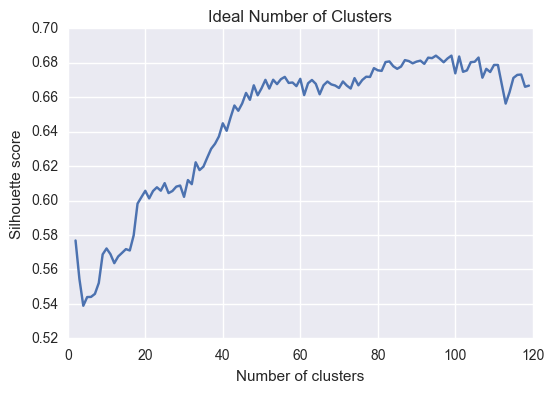

In [368]:
# This takes ~30 minutes to run
sample_silhouette_score(df_data_no_date_dummy)

- ~ 100 is the ideal nuber of clusters here. For simplicity, we used sixty clusters


In [370]:
def find_avg_centroid(dataframe_input,cluster_size=60):
    """Using the cluster size for the number of centers, find the centers in the dataset"""
    sample = dataframe_input
    knn_classifier = KMeans(cluster_size)
    fit_knn = knn_classifier.fit(X=sample.values)
    predicted_labels = fit_knn.labels_
    centers = fit_knn.cluster_centers_
    return centers



In [371]:
## store the cluster centers
average_cluster_centers = find_avg_centroid(df_data_no_date_dummy)

# Now, find the center that each row is closest to and assign to that cluster number.
- Define a euclidean distance function.

In [18]:
def euclidean_distance(a,b):
    """Expects numpy array and returns the euclidan distance between them"""
    return sqrt(sum((a-b)**2))

In [19]:

def assign_cluster_center(dataframe_input,centroids):
    """Take in a dataframe, iterate through the rows and find the closest center to each row.
    Returns the same dataframe with a new column indicating the closest cluster."""
    dataframe_input = dataframe_input.copy() 
    list_of_min_distances = []
    list_of_cluster_numbers = []
    for row in dataframe_input.iterrows():
        row_array=np.array(row[1])
        min_distance = 9999999999999999
        min_distance_cluster_number = 0
        for center_number,center in enumerate(centroids):
            center = np.array(center)
            distance = euclidean_distance(center, row_array)
            if distance < min_distance:
                min_distance = distance
                min_distance_cluster_number = center_number
        list_of_min_distances.append(min_distance)
        list_of_cluster_numbers.append(min_distance_cluster_number)
    dataframe_input['cluster_number']=list_of_cluster_numbers
    return dataframe_input
        


In [20]:
# create a new DF with added columns for the cluster it belongs to as well as distance to that cluster
df_data_clusters_dummy_no_date = assign_cluster_center(df_data_no_date_dummy,average_cluster_centers)

In [21]:
df_data_clusters_dummy_no_date.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,car_type_N,car_type_R,car_type_U,cluster_number
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,1.0,0.0,0.0,20
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,1
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,50
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,1.0,0.0,0.0,48
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,1.0,0.0,0.0,30


# Next, create a random forest prediction of outcome per cluster_number

In [23]:
list_of_centroids = [i for i in range(60)]

In [124]:
def create_model_per_cluster(dataframe_in,list_of_clusters):
    """Create a logistic regression model for each cluster to predict outcome.
    Return a dictionary where the key
    is the cluster number and the value is the trained model.
    Also returns a dictionary of RMSE per cluster"""
    rmse_per_cluster = {}
    list_of_models_per_cluster = {}
    for cluster in list_of_clusters:
        cluster_df = dataframe_in[dataframe_in.cluster_number==cluster]
        df_X =cluster_df.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Rate', 'Partner Bin', \
       'previous_rate', 'competition_rate', 'cost_of_funds',\
        'car_type_N', 'car_type_R', 'car_type_U')]
        df_y = cluster_df['Outcome']
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
        df_X, df_y, test_size=0.33)
        # create the classifier
        Log_classifier_model = LogisticRegression()
        Log_classifier_model .fit(X_train,y_train)
        classifier_predictions = Log_classifier_model .predict(X_test)
        rmse = np.linalg.norm(y_test - classifier_predictions)/sqrt(len(y_test))
        rmse_per_cluster[cluster]=rmse
        list_of_models_per_cluster[cluster]=Log_classifier_model 
    return rmse_per_cluster,list_of_models_per_cluster

In [125]:
rmse_per_cluster, dict_of_models_per_cluster = create_model_per_cluster(df_data_clusters_dummy_no_date,list_of_centroids)

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


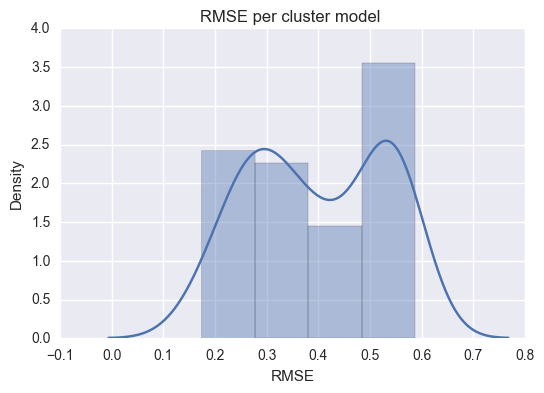

In [364]:
sns.distplot(list(rmse_per_cluster.values()))
plt.title('RMSE per cluster model ')
plt.ylabel('Density')
plt.xlabel('RMSE')

In [26]:
df_data_clusters_dummy_no_date.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,car_type_N,car_type_R,car_type_U,cluster_number
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,1.0,0.0,0.0,20
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,1
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,50
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,1.0,0.0,0.0,48
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,1.0,0.0,0.0,30


In [126]:
dict_of_models_per_cluster

{0: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 1: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 2: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 3: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', 

# Next, change the rate offered to each cluster, and see what the impact on prediction is.
- Start at APR of 1% and go up to 10%
- Assume all loans start at the same time

In [243]:
apr_rate = [i for i in np.linspace(3,15,15)]

In [255]:
# Define a NPV function
def npv_loan_amount(loan, term, APR, cost_of_capital):
    """Return the npv given the parameters above"""
    interest = loan*APR # http://mathforum.org/dr.math/faq/faq.interest.html
    Cfs = []
    Cfs.append(-loan)
    for i in range(1,int(term/12)+1):
        Cfs.append(interest)
    Cfs[-1] += loan

    disc_Cfs = []
    for t,cf in enumerate(Cfs):
         disc_Cfs.append(cf / (1+cost_of_capital)**t)
    return sum(disc_Cfs)
    
npv_loan_amount(1000, 60, 0.07, 0.01) 


291.20587435950711

In [244]:
def outcome_per_apr_rate(dataframe_in,dict_of_models,list_of_clusters,list_of_apr):
    """Change the APR per cluster and predict outcome.
    Return a dictionary of a list of tuplues where the initial key = cluster number and value = a list
    The second (inside) list has the apr as the key and NPV and the value for each tuple.
    Also returns each clusters max APR rate as well as max NPV rate in the form of a dict."""
    cluster_apr_npv = defaultdict(list)
    max_apr_per_cluster = defaultdict(int)
    max_npv_per_cluster = defaultdict(int)
    for cluster in list_of_clusters: ## which cluster are we looking at
        current_model = dict_of_models[cluster]
        apr_npv_per_cluster = []
        cluster_df = dataframe_in[dataframe_in.cluster_number==cluster]
        for apr_rate in list_of_apr:
            # Change the APR rate for the entire cluster
            cluster_df.Rate = apr_rate 
            df_X =cluster_df.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Rate', 'Partner Bin', \
           'previous_rate', 'competition_rate', 'cost_of_funds',\
            'car_type_N', 'car_type_R', 'car_type_U')]
            df_y = cluster_df.loc[:,'Outcome']
            cluster_df['predictions']=current_model.predict(df_X)
            cluster_df['npv'] = \
            cluster_df.apply(lambda x: npv_loan_amount(x['predictions']*x['Amount'],
                                                       x['Term'],
                                                       x['Rate'],
                                                       x['cost_of_funds']), axis=1)
            apr_npv_per_cluster.append((apr_rate,sum(cluster_df['npv'])))
        cluster_apr_npv[cluster] = apr_npv_per_cluster
        # get max apr and max npv for each cluster
        max_apr_per_cluster[cluster] = max(cluster_apr_npv[cluster] ,key=itemgetter(1))[0]
        max_npv_per_cluster[cluster] = max(cluster_apr_npv[cluster] ,key=itemgetter(1))[1]
        print("Finished calculating NPV for cluster {}".format(cluster))
    return cluster_apr_npv, max_apr_per_cluster, max_npv_per_cluster
    

In [233]:
np.shape(df_data_clusters_dummy_no_date)

(208077, 14)

In [245]:
list_cluster_apr_npv, max_apr,max_npv = outcome_per_apr_rate(df_data_clusters_dummy_no_date,dict_of_models_per_cluster ,list_of_centroids,apr_rate )

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Finished calculating NPV for cluster 0
Finished calculating NPV for cluster 1
Finished calculating NPV for cluster 2
Finished calculating NPV for cluster 3
Finished calculating NPV for cluster 4
Finished calculating NPV for cluster 5
Finished calculating NPV for cluster 6
Finished calculating NPV for cluster 7
Finished calculating NPV for cluster 8
Finished calculating NPV for cluster 9
Finished calculating NPV for cluster 10
Finished calculating NPV for cluster 11
Finished calculating NPV for cluster 12
Finished calculating NPV for cluster 13
Finished calculating NPV for cluster 14
Finished calculating NPV for cluster 15
Finished calculating NPV for cluster 16
Finished calculating NPV for cluster 17
Finished calculating NPV for cluster 18
Finished calculating NPV for cluster 19
Finished calculating NPV for cluster 20
Finished calculating NPV for cluster 21
Finished calculating NPV for cluster 22
Finished calculating NPV for cluster 23
Finished calculating NPV for cluster 24
Finished c

In [258]:
list_cluster_apr_npv

defaultdict(list,
            {0: [(3.0, 71310648.7235485),
              (3.8571428571428572, 89526159.30260417),
              (4.7142857142857144, 91691106.10966633),
              (5.5714285714285712, 83768341.60743254),
              (6.4285714285714288, 75214012.13704154),
              (7.2857142857142856, 71440957.51243167),
              (8.1428571428571423, 64848631.281646244),
              (9.0, 32854200.807686247),
              (9.8571428571428577, 9738478.500106517),
              (10.714285714285714, 2469225.334703968),
              (11.571428571428571, 1036934.5255205629),
              (12.428571428571429, 475144.7180898124),
              (13.285714285714285, 113852.35434788359),
              (14.142857142857142, 0.0),
              (15.0, 0.0)],
             1: [(3.0, 3293163.679872714),
              (3.8571428571428572, 4694328.3302254435),
              (4.7142857142857144, 6115258.582728245),
              (5.5714285714285712, 7182190.483540021),
             

In [256]:
max_apr

defaultdict(int,
            {0: 4.7142857142857144,
             1: 15.0,
             2: 7.2857142857142856,
             3: 3.0,
             4: 3.8571428571428572,
             5: 3.0,
             6: 10.714285714285714,
             7: 3.0,
             8: 3.0,
             9: 9.8571428571428577,
             10: 13.285714285714285,
             11: 3.0,
             12: 4.7142857142857144,
             13: 3.0,
             14: 4.7142857142857144,
             15: 5.5714285714285712,
             16: 3.0,
             17: 15.0,
             18: 9.8571428571428577,
             19: 4.7142857142857144,
             20: 14.142857142857142,
             21: 3.0,
             22: 11.571428571428571,
             23: 3.0,
             24: 3.0,
             25: 4.7142857142857144,
             26: 4.7142857142857144,
             27: 6.4285714285714288,
             28: 5.5714285714285712,
             29: 11.571428571428571,
             30: 15.0,
             31: 9.0,
             32:

In [257]:
max_npv

defaultdict(int,
            {0: 91691106.10966633,
             1: 15595968.53992648,
             2: 8420462.586506061,
             3: 0.0,
             4: 5308740.438452114,
             5: 0.0,
             6: 39820146.86705119,
             7: 0.0,
             8: 0.0,
             9: 10627409.11604954,
             10: 7272416.893670261,
             11: 0.0,
             12: 43647370.69407616,
             13: 0.0,
             14: 72222717.83798762,
             15: 19503359.28068262,
             16: 0.0,
             17: 1379713.6652770662,
             18: 11782229.770685699,
             19: 94496070.85926488,
             20: 5648740.189168199,
             21: 0.0,
             22: 8116814.459297081,
             23: 0.0,
             24: 0.0,
             25: 82944798.75112428,
             26: 65834599.96100875,
             27: 9573389.459829079,
             28: 9959182.633037446,
             29: 29620597.287782613,
             30: 5440228.438762986,
             3

In [252]:
npv_max = 0
for k,v in max_npv.items():
    npv_max +=v

In [253]:
npv_max

1386193643.5484447

In [264]:
npv_loan_amount(npv_max,24,.056,.014)

114039879.47869444

In [161]:


max(cluster_apr_npv[0] ,key=itemgetter(1))

(4.1666666666666661, 92101924.77954046)

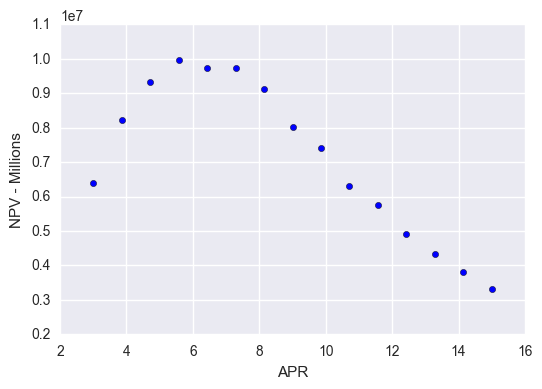

In [336]:
 plt.scatter(*zip(*list(list_cluster_apr_npv[28])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

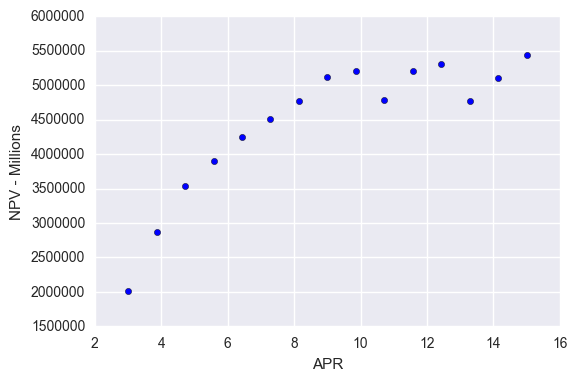

In [335]:
 plt.scatter(*zip(*list(list_cluster_apr_npv[30])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

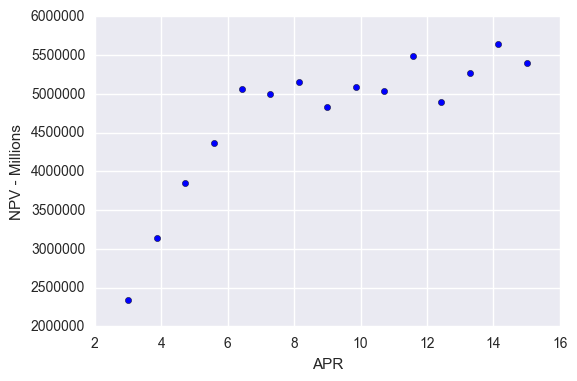

In [334]:
 plt.scatter(*zip(*list(list_cluster_apr_npv[20])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

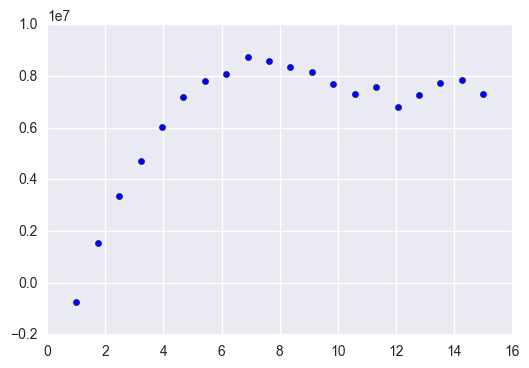

In [238]:
 plt.scatter(*zip(*list(list_cluster_apr_npv[2])))
    plt.ylabel('NPV - Millions')
    plt.xlabel('APR')

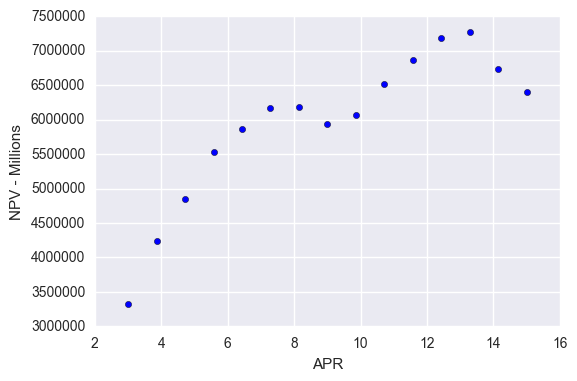

In [262]:
plt.scatter(*zip(*list(list_cluster_apr_npv[10])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

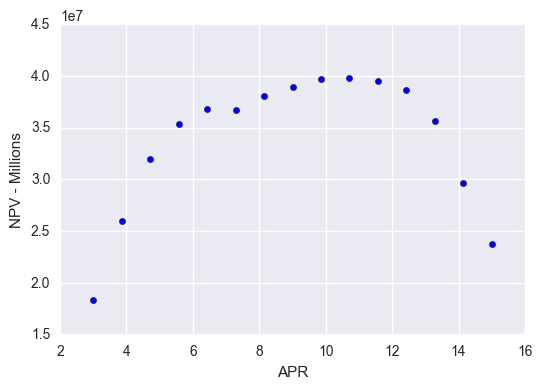

In [261]:
plt.scatter(*zip(*list(list_cluster_apr_npv[6])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

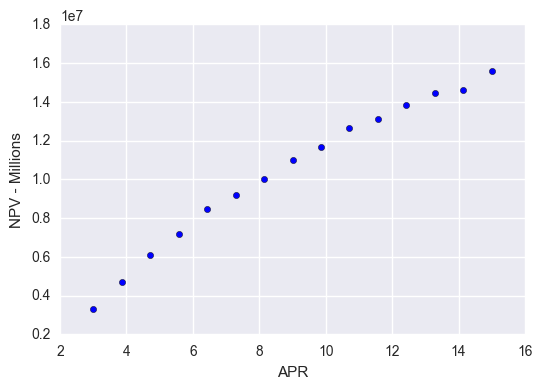

In [260]:
plt.scatter(*zip(*list(list_cluster_apr_npv[1])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

In [331]:
np.shape(df_data_clusters_dummy_no_date[(df_data_clusters_dummy_no_date.cluster_number==1) ])

(7392, 14)

In [327]:
df_data_clusters_dummy_no_date[(df_data_clusters_dummy_no_date.cluster_number==1) & (df_data_clusters_dummy_no_date.Outcome==1)]

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,car_type_N,car_type_R,car_type_U,cluster_number
1496,4.0,665.0,60.0,39499.93,1.0,7.99,2.0,0.00,5.80,1.8400,0.0,0.0,1.0,1
1510,2.0,728.0,48.0,40000.00,1.0,5.79,3.0,0.00,5.49,1.8400,1.0,0.0,0.0,1
6481,2.0,708.0,72.0,39585.17,1.0,5.95,3.0,0.00,6.25,1.7800,1.0,0.0,0.0,1
7563,1.0,765.0,48.0,40000.00,1.0,4.85,1.0,0.00,5.49,1.7975,1.0,0.0,0.0,1
7999,1.0,744.0,60.0,40000.00,1.0,4.85,3.0,0.00,5.49,1.8050,1.0,0.0,0.0,1
8275,2.0,711.0,60.0,39999.99,1.0,5.35,1.0,0.00,5.75,1.8063,0.0,0.0,1.0,1
8688,2.0,729.0,72.0,39781.95,1.0,5.95,1.0,0.00,6.25,1.8113,1.0,0.0,0.0,1
8719,3.0,685.0,72.0,40494.83,1.0,6.64,3.0,0.00,6.25,1.8113,1.0,0.0,0.0,1
9564,1.0,742.0,60.0,40000.00,1.0,4.57,1.0,0.00,5.49,1.8200,1.0,0.0,0.0,1
10411,4.0,650.0,72.0,40109.36,1.0,7.89,1.0,0.00,6.25,1.8200,1.0,0.0,0.0,1


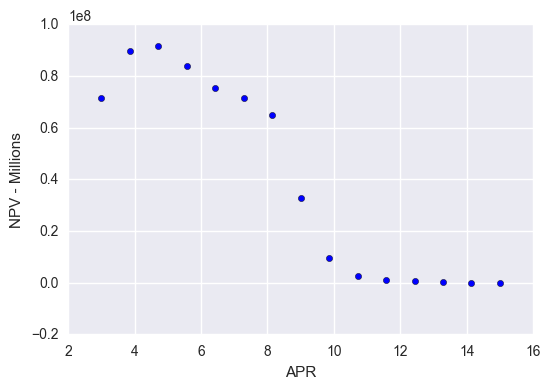

In [267]:
 plt.scatter(*zip(*list(list_cluster_apr_npv[0])))
plt.ylabel('NPV - Millions')
plt.xlabel('APR')

# Next, compare the average APR of each cluster before, and after, the optimzation to see the difference.


In [286]:
def avg_cluster_apr(dataframe_in,cluster_list):
    """Get avg. apr per cluster"""
    avg_apr_per_cluster = defaultdict(int)
    for cluster in cluster_list:

        df_cluster = dataframe_in[dataframe_in.cluster_number==cluster]
        avg_apr_per_cluster[cluster]=np.mean(df_cluster.Rate)

    return avg_apr_per_cluster


In [282]:
df_data_clusters_dummy_no_date.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,car_type_N,car_type_R,car_type_U,cluster_number
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,1.0,0.0,0.0,20
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,1
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,1.0,0.0,0.0,50
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,1.0,0.0,0.0,48
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,1.0,0.0,0.0,30


In [289]:
avg_apr_per_cluster_original = avg_cluster_apr(df_data_clusters_dummy_no_date,list_of_centroids)

In [304]:
difference_in_rates_new_minus_original = np.array(list(max_apr.values())) - np.array(list(avg_apr_per_cluster_original.values()))

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


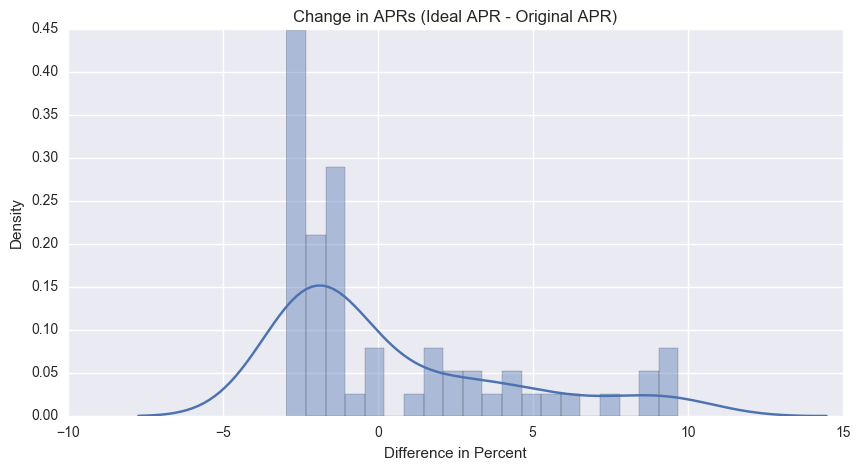

In [366]:
plt.figure(figsize=(10,5))
#sns.barplot(x=list_of_centroids,y=difference_in_rates_new_minus_original )
sns.distplot(difference_in_rates_new_minus_original,bins=20)
plt.ylabel('Density')
plt.title('Change in APRs (Ideal APR - Original APR)')
plt.xlabel("Difference in Percent")

In [344]:
def avg_cluster_competitor_apr(dataframe_in,cluster_list):
    """Get avg. apr per cluster for the competitor rate"""
    avg_apr_per_cluster = defaultdict(int)
    for cluster in cluster_list:

        df_cluster = dataframe_in[dataframe_in.cluster_number==cluster]
        avg_apr_per_cluster[cluster]=np.mean(df_cluster.competition_rate)

    return avg_apr_per_cluster


In [345]:
avg_apr_per_cluster_competitor_original = avg_cluster_competitor_apr(df_data_clusters_dummy_no_date,list_of_centroids)

In [346]:
difference_in_rates_new_minus_original_COMPETITOR = np.array(list(max_apr.values())) - np.array(list(avg_apr_per_cluster_competitor_original .values()))

In [349]:
difference_in_rates_new_minus_original

array([-1.25547761,  9.70014746,  1.71449477, -2.47      , -1.90718198,
       -2.41069317,  4.7923493 , -2.25167213, -2.47644792,  4.51894974,
        7.59493799, -2.50605263, -1.07214764, -2.36531315, -1.26915459,
       -0.15451548, -2.30236652,  9.6718422 ,  4.41968442, -1.16600198,
        8.75532566, -2.4862963 ,  6.2867424 , -2.3488709 , -2.56080214,
       -1.18437112, -1.31714828,  0.9233242 , -0.07088068,  5.67822344,
        9.65001248,  3.29120614, -2.31074006, -1.88920658,  2.590257  ,
       -2.949     ,  0.1688117 , -1.32519539, -2.26398304,  2.1296682 ,
        3.59769028,  1.72574264, -1.28961848, -1.52275985,  1.84183958,
       -2.36827586,  3.32934847, -1.00625404, -1.18506424, -2.42282363,
       -1.91805318, -2.39681159, -2.82676471, -2.00713863,  8.53573719,
       -2.47173145, -2.83156863, -2.36180527, -1.29208291, -2.34541176])

In [348]:
difference_in_rates_new_minus_original_COMPETITOR

array([ -0.2168667 ,  10.30166531,   2.44652233,  -1.83641566,
        -0.90216394,  -1.81922733,   5.94512868,  -1.78613115,
        -1.83407292,   5.16372834,   8.53371534,  -1.74526316,
        -0.10679991,  -1.71906573,  -0.16399092,   0.62667721,
        -1.67383838,  10.21773512,   5.04002647,  -0.14287897,
         9.42264537,  -1.58851852,   6.79233815,  -1.74624951,
        -1.62122995,  -0.19395138,  -0.08014096,   1.60908942,
         0.71107472,   6.84244838,  10.22403994,   4.11256579,
        -1.75318224,  -1.02951891,   3.28631191,  -1.67025   ,
         0.75360645,  -0.17692004,  -0.97254196,   3.46096774,
         4.1763888 ,   2.40153022,  -0.10586997,  -0.91284273,
         2.48556992,  -1.79602245,   4.13376308,  -0.21837293,
        -0.22266285,  -1.8375934 ,  -1.01103115,  -1.81839817,
        -1.71470588,  -1.04722742,   9.3503143 ,  -1.81212014,
        -1.48568627,  -1.8051217 ,  -0.07168645,  -1.75876471])

/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


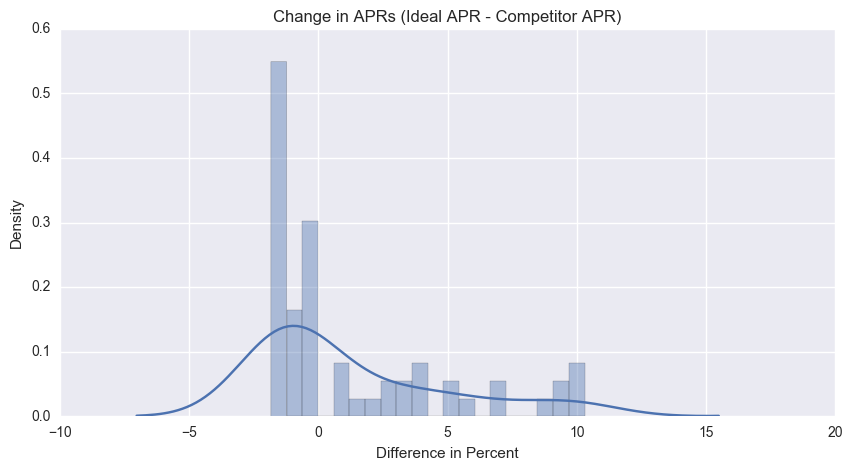

In [365]:
plt.figure(figsize=(10,5))
#sns.barplot(x=list_of_centroids,y=difference_in_rates_new_minus_original )
sns.distplot(difference_in_rates_new_minus_original_COMPETITOR,bins=20)
plt.ylabel('Density')
plt.title('Change in APRs (Ideal APR - Competitor APR)')
plt.xlabel("Difference in Percent")

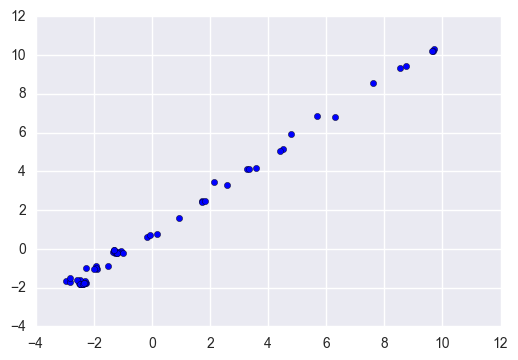

In [351]:
plt.scatter(difference_in_rates_new_minus_original,difference_in_rates_new_minus_original_COMPETITOR)